In [185]:
import sys, time, os, re
from matplotlib import colors, cm, rc
import matplotlib.pyplot as plt
from tqdm import tqdm
import corner
from astropy import cosmology
import numpy as np

import pickle
import pandas as pd

from ksz.parameters import *

In [3]:
props = dict(boxstyle="round", facecolor="white", alpha=0.5)
rc('font',**{'family':'serif', 'serif':['times new roman'], 'size': 16})
rc('text', usetex=True)
rc('axes', linewidth = 1.5)

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [202]:
cos = cosmology.Planck18
#ells = np.arange(500, 10000, step=500)

ells = np.load('ells_for_regressor.npy')
delta_ell = np.diff(ells).mean()
print(ells.size, delta_ell)

25 606.020202020202


In this notebook, we perform a Fisher forecast to better understand the results of our MCMC. Indeed, in a Fisher formalism, it is possible to derive the posterior distributions of the fit analytically.

# Fisher forecast

Given a posterior distribution $P(\theta\vert\mathrm{data})$ for model parameters $\theta$, the Fisher-matrix components are given by:
\begin{equation}
\mathcal{F}_{i j}=-\left\langle\frac{\partial^2 \ln P}{\partial \theta_i \partial \theta_j}\right\rangle.
\end{equation}
The Cramér-Rao theorem states that any unbiased estimator for the parameters will produce a covariance matrix that is no more accurate than $\mathcal{F}^{-1}$: thus the Fisher matrix can be used to estimate the minimum uncertainties of parameters given observations (e.g., Albrecht+2009).

Here, are observables are the patchy kSZ angular power spectrum $C_\ell^\mathrm{kSZ}$ at $\ell=3000$ and the dimensionless 21cm power spectrum $\Delta_{21}(k, z)$ at two points: $z=7.9$, $k=0.50\,\mathrm{Mpc}^{-1}$ and $z=10.4$, $k=0.53\,\mathrm{Mpc}^{-1}$. Let us gather these three data points in an observable vector $\mathbf{o}$ of dimension 3. We have $\mathbf{\Pi}$ the data covariance matrix of dimension (3, 3). Given the parameter set $\theta \equiv (z_{\mathrm{re}}, z_{\mathrm{end}})$, and assuming the posterior distribution can be described as Gaussian, we define the $(i, j)$ element of the Fisher matrix as
\begin{equation}
\mathcal{F}_{ij}= \frac{\partial \mathbf{o}^T}{\partial \theta_i}\mathbf{\Pi}^{-1}\frac{\partial \mathbf{o}}{\partial \theta_j}.
\end{equation}
In these ideal conditions, the inverse of the Fisher matric is the covariance matrix $\mathcal{C}=\mathcal{F}^{-1}$ and the forecast uncertainty of the $i$th parameter is $\sigma(\theta_i)=\sqrt{\mathcal{C}_{ii}}$.

## Data points and covariance matrix

Let's produce mock data points and covariance matrix.

In [205]:
datapoints = regressor.predict(np.asarray(theta_true)[None,:]).flatten()

In [206]:
def sample_var(ls, dl, telescope, bin_width=100):
    if np.shape(ls) != np.shape(dl):
        raise ValueError('ls and dl must have the same shape.')
    dDl = dl * np.sqrt(2./telescope['fsky']/(2.*ls+1.))
    return dDl


def noise(ls, telescope, pol=False, is_cl=False):
    ls = np.atleast_1d(ls)
    sig0 = telescope['noise'] / 60.0 * np.pi / 180.0 # arcmin to rad
    fwhm = telescope['fwhm'] / 60.0 * np.pi / 180.0 # arcmin to rad
    nl = sig0**2 / 2. * np.exp(ls*(ls+1.)*fwhm**2/8./np.log(2.))
    if pol:
        nl *= 2.
    if not is_cl:
        nl *= ls*(ls+1.)/2./np.pi
    return nl

In [241]:
a682 = np.load('a682_MLerror.npy')
b682 = np.load('b682_MLerror.npy')

emu_error = np.maximum(np.abs(a682), b682)

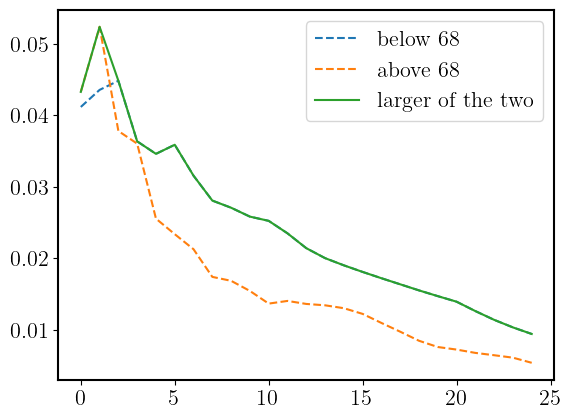

In [300]:
 plt.plot(np.abs(a682), ls='--', label='below 68%')
 plt.plot(np.abs(b682), ls='--', label='above 68%')
 
plt.plot(emu_error, label='larger of the two')

plt.legend()

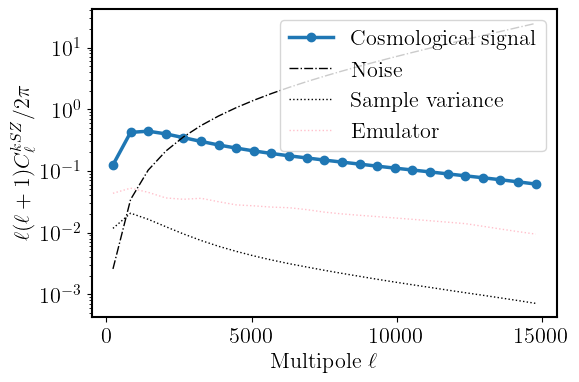

In [285]:
telescope_specs = {'fsky':0.5, 'fwhm':0.5, 'noise':2.7,}  # cmb-h4
# telescope_specs = {'fsky':1., 'fwhm':1., 'noise':.01}  # ideal

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.semilogy(ells, datapoints, ls='-', color='C0', lw=2.5, marker='o', label='Cosmological signal')
ax.plot(ells, noise(ells, telescope_specs, pol=False), ls='-.', color='k', lw=1., label='Noise')
ax.plot(ells, sample_var(ells, datapoints, telescope_specs), ls=':', color='k', lw=1., label='Sample variance')
ax.plot(ells, emu_error, ls=':', color='pink', lw=1., label='Emulator')
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$\ell(\ell+1)C_\ell^{kSZ}/2\pi$')
ax.legend()


In [271]:
print('The error for the first ell is:')
print(f'sample variance: {(sample_var(ells, datapoints, telescope_specs)**2)[0]:2f}')
print(f'noise: {((noise(ells, telescope_specs, pol=False)/np.sqrt(delta_ell))**2)[0]:.10f}')
print(f'emulator: {((emu_error/np.sqrt(delta_ell))**2)[0]:.10f}')


The error for the first ell is:
sample variance: 0.000136
noise: 0.0000000109
emulator: 0.0000030927


In [280]:
(sample_var(ells, datapoints, telescope_specs)**2), (noise(ells, telescope_specs, pol=False)/np.sqrt(delta_ell))**2

(array([1.36399215e-04, 4.23892016e-04, 2.68339278e-04, 1.54514818e-04,
        9.02010164e-05, 5.52503281e-05, 3.57369727e-05, 2.45007408e-05,
        1.74340065e-05, 1.28844898e-05, 9.77281847e-06, 7.61539621e-06,
        5.96419609e-06, 4.74160972e-06, 3.79808803e-06, 3.05104703e-06,
        2.47370928e-06, 2.02400563e-06, 1.65912824e-06, 1.35972498e-06,
        1.11796338e-06, 9.23290767e-07, 7.58959263e-07, 6.21410390e-07,
        5.04607364e-07]),
 array([1.08924076e-08, 1.94108676e-06, 1.74077848e-05, 7.20529275e-05,
        2.07785378e-04, 4.86300781e-04, 9.94240308e-04, 1.85040201e-03,
        3.21558744e-03, 5.30588627e-03, 8.41049262e-03, 1.29155362e-02,
        1.93359362e-02, 2.83579946e-02, 4.08964128e-02, 5.81707303e-02,
        8.18079864e-02, 1.13980877e-01, 1.57594084e-01, 2.16536139e-01,
        2.96020701e-01, 4.03050118e-01, 5.47046724e-01, 7.40714827e-01,
        1.00122089e+00]))

In [281]:
(sample_var(ells, datapoints, telescope_specs)**2 + (noise(ells, telescope_specs, pol=False)/np.sqrt(delta_ell))**2)

array([1.36410107e-04, 4.25833103e-04, 2.85747062e-04, 2.26567746e-04,
       2.97986395e-04, 5.41551109e-04, 1.02997728e-03, 1.87490275e-03,
       3.23302145e-03, 5.31877076e-03, 8.42026543e-03, 1.29231516e-02,
       1.93419004e-02, 2.83627362e-02, 4.09002109e-02, 5.81737814e-02,
       8.18104601e-02, 1.13982901e-01, 1.57595743e-01, 2.16537499e-01,
       2.96021819e-01, 4.03051041e-01, 5.47047483e-01, 7.40715448e-01,
       1.00122140e+00])

The error bars are drawn from the diagonal terms of the data covariance matrix $\mathbf{\Pi}$:

In [301]:
err_cov = np.diag(sample_var(ells, datapoints, telescope_specs)**2
                    + (noise(ells, telescope_specs, pol=False)/np.sqrt(delta_ell))**2)

err_cov_emu = np.diag(sample_var(ells, datapoints, telescope_specs)**2
                    + (noise(ells, telescope_specs, pol=False)/np.sqrt(delta_ell))**2 
                    + (emu_error/np.sqrt(delta_ell))**2)

In [315]:
icov = np.linalg.inv(err_cov)
icov_emu = np.linalg.inv(err_cov_emu)

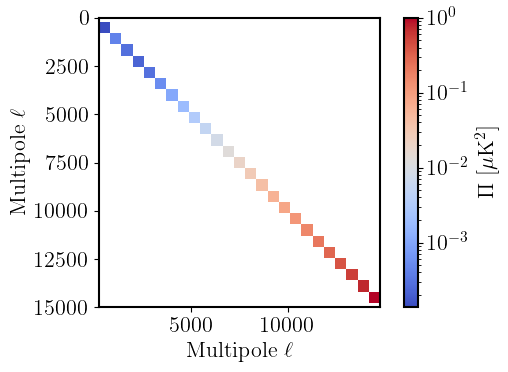

In [303]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
norm = matplotlib.colors.LogNorm(np.diag(err_cov).min(), np.diag(err_cov).max())
im = ax.imshow(err_cov, cmap='coolwarm', norm=norm,
            extent=(ells.min(), ells.max(), ells.max(), ells.min())
            )
cbar = plt.colorbar(im, ax=ax, fraction=0.045, label=r'$\Pi$ [$\mu$K$^2$]')
ax.set_yticks(ax.get_xticks())
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'Multipole $\ell$')
fig.tight_layout()

array([<Axes: title={'center': 'No emulator error'}, xlabel='Multipole $\\ell$', ylabel='$\\ell(\\ell+1)C_\\ell^{kSZ}/2\\pi$'>,
       <Axes: title={'center': 'Emulator error'}, xlabel='Multipole $\\ell$'>],
      dtype=object)

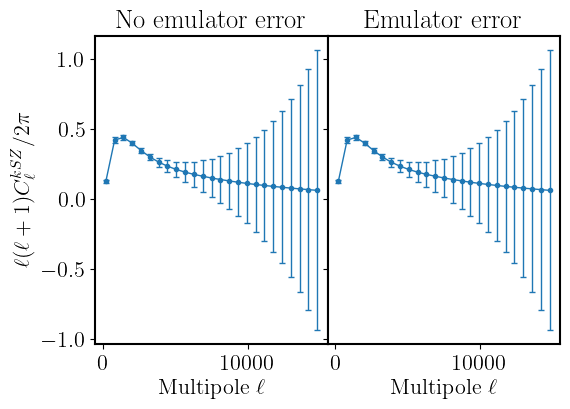

In [304]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.0)

ax[0].errorbar(
    ells, datapoints, yerr=np.sqrt(np.diag(err_cov)),
    lw=1., marker='.', capsize=2.)

ax[1].errorbar(
    ells, datapoints, yerr=np.sqrt(np.diag(err_cov_emu)),
    lw=1., marker='.', capsize=2.)
ax[0].set_xlabel(r'Multipole $\ell$')
ax[1].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$\ell(\ell+1)C_\ell^{kSZ}/2\pi$')

ax[0].set_title('No emulator error')
ax[1].set_title('Emulator error')

ax

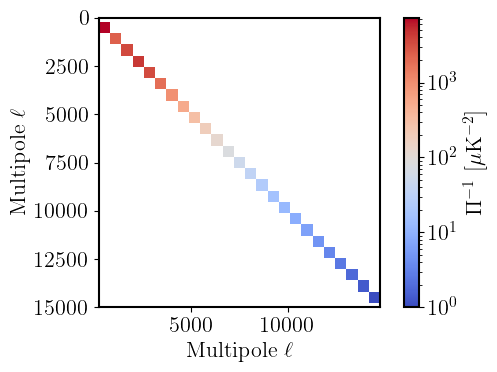

In [305]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
norm = matplotlib.colors.LogNorm(np.diag(icov).min(), np.diag(icov).max())
im = ax.imshow(
    icov, cmap='coolwarm', norm=norm,
    extent=(ells.min(), ells.max(), ells.max(), ells.min())
)
cbar = plt.colorbar(im, ax=ax, fraction=0.045, label=r'$\Pi^{-1}$ [$\mu$K$^{-2}$]')
ax.set_yticks(ax.get_xticks())
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'Multipole $\ell$')
fig.tight_layout()


## Derivatives

Let us use the approximation:
\begin{equation}
\frac{\partial f}{\partial x}\biggr\rvert_{x_0,y_0} \simeq \frac{f(x_0+\Delta x, y_0)-f(x_0-\Delta x, y_0)}{2 \Delta x}
\end{equation}
for $\Delta x \ll x_0$.

Pick a central value of the parameters and deviations around them:

In [217]:
#df = pd.read_csv('/Users/emcbride/catwoman/scripts/Loreli_data.db')
df = pd.read_csv('/Users/emcbride/kSZ/data/LoreLi_summaries/Loreli_data.db')
df.set_index('sim_n', inplace=True)
df.index = df.index.astype(str)
df.drop(columns='Unnamed: 0', inplace=True)

In [218]:
sims = []
for filename in os.listdir('/Users/emcbride/spectra/kSZ/LoReLi'):
    #files_LoReLi.append(filename)
    match = re.search(r'\d{5}', filename)
    sims.append(match.group())

print(f'{len(sims)} sims available')

1016 sims available


In [219]:
df = df.loc[sims]
df = df[astro_labels]

In [220]:
astro_labels

['Xray_Lfunc',
 'hard_Xray_fraction',
 'gasconversion_timescale',
 'log10_Mmin',
 'ion_escapefrac_post']

In [221]:
theta_true =  df[astro_labels].mean().to_numpy()[:] # to fill
print(theta_true)
theta_labels = astro_pnames_formatted[:]
prior_bounds = [(t * .5, t * 1.5) for t in theta_true]
print(prior_bounds)

[4.65378898e-03 5.06692913e-01 3.23520994e+03 8.77045276e+00
 2.43110236e-01]
[(np.float64(0.002326894488188976), np.float64(0.006980683464566928)), (np.float64(0.25334645669291345), np.float64(0.7600393700787403)), (np.float64(1617.6049704724408), np.float64(4852.814911417322)), (np.float64(4.3852263779527565), np.float64(13.15567913385827)), (np.float64(0.1215551181102362), np.float64(0.36466535433070857))]


In [84]:
theta_labels

['$L_X$', '$f_X$', '$\\tau$', '$M_{\\text{min}}$', '$f_{\\text{esc}}$']

We will get the derivative at $\pm 5\%$ from the central value in `theta_true`.

In [61]:
dev = 0.05 # %

In [134]:
def dobs_dz(theta, idz, lrange=ells, dev=0.05):
    """
    Method to obtain derivative of model wrt parameter #idz
    Parameters
    ----------
        theta: array or list of floats
            List of fiducial model parameter values.
        idz: int
            Index of the parameter to derive wrt in theta.
        lrange: array of floats
            List of multipoles the data is available on.
        dev: float
            Deviation with respect to fiducial value.
    """

    norm = matplotlib.colors.Normalize(vmin=.39, vmax=.51)
    cmap = plt.get_cmap('viridis_r')

    print(cmap(norm(dev)))
    
    #assert np.size(theta) == 4
    assert (idz >= 0) and (idz < np.size(theta))
    assert dev < 1

    # get bounds
    theta_max = np.copy(theta)
    theta_max[idz] = theta[idz]*(1+dev)
    ksz_ps_max = regressor.predict(theta_max[None,:]).flatten()

    theta_min = np.copy(theta)
    theta_min[idz] = theta[idz]*(1-dev)
    ksz_ps_min = regressor.predict(theta_min[None,:]).flatten()

    plt.plot(ells, ksz_ps_max /  ksz_ps_min, label=f'dev={dev:.3f}')
    plt.legend()

    deriv_ksz = (ksz_ps_max-ksz_ps_min) / (theta_max[idz]-theta_min[idz])

    return deriv_ksz


### With respect to param 1

To repeat for each model parameter. Here for the first parameter of the parameterset (`idz=0`)

In [89]:
# Load the model from the file
with open('kSZ_25bins_5params_regressor.pkl', 'rb') as f:
    regressor = pickle.load(f)

In [201]:
ells = np.load('ells_for_regressor.npy')
ells.size

25

In [ ]:
ells

In [90]:
# Use the loaded model
predictions = regressor.predict(np.asarray(theta_true)[None,:])

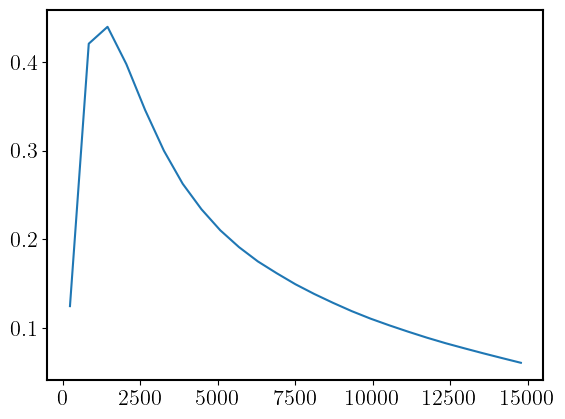

In [91]:
plt.plot(ells, predictions.flatten())

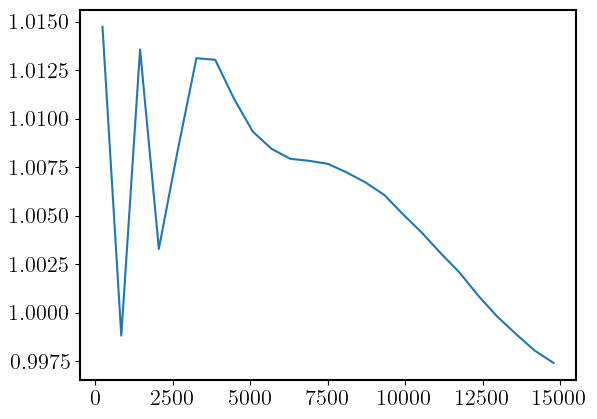

In [92]:
deriv_ksz_1 = dobs_dz(theta_true, idz=, dev=dev, lrange=ells)

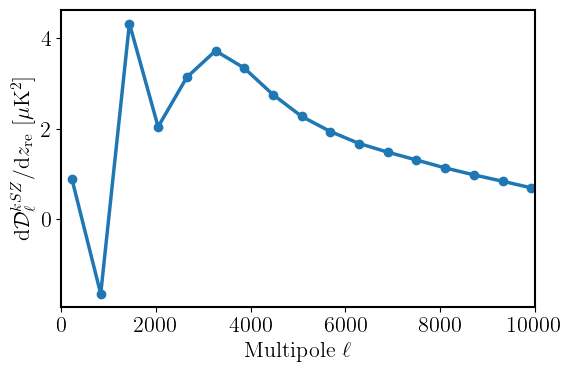

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(ells, deriv_ksz_1, ls='-', color='C0', lw=2.5, marker='o')
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'd$\mathcal{D}_\ell^{kSZ}/$d$z_\mathrm{re}$ [$\mu$K$^2$]')
# ax.set_ylim(bottom=1e-6)
ax.set_xlim(0, 10000)
fig.tight_layout()

(np.float64(0.993248), np.float64(0.906157), np.float64(0.143936), np.float64(1.0))
(np.float64(0.993248), np.float64(0.906157), np.float64(0.143936), np.float64(1.0))
(np.float64(0.993248), np.float64(0.906157), np.float64(0.143936), np.float64(1.0))
(np.float64(0.993248), np.float64(0.906157), np.float64(0.143936), np.float64(1.0))
(np.float64(0.565498), np.float64(0.84243), np.float64(0.262877), np.float64(1.0))


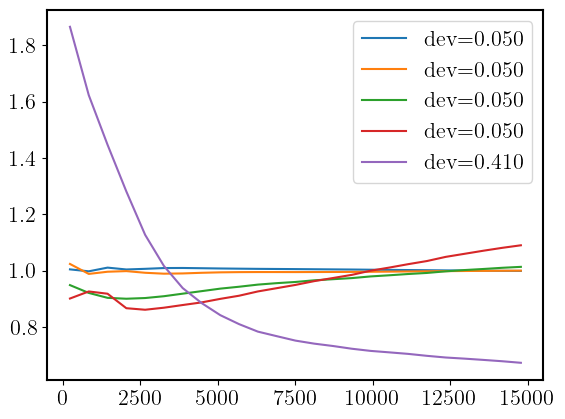

In [223]:
derivs = []

for i in range(theta_true.size):
    dev = .05
    if i == 4:
        dev = .41

    dtheta = dobs_dz(theta_true, idz=i, dev=dev, lrange=ells)
    derivs.append(dtheta)

## Fisher and covariance matrix

Applying the equations above giving the Fisher matrix in terms of the derivative of the observables with respect to model parameters, we get:

### Fisher for kSZ

In [316]:
fish_ksz = np.zeros((len(theta_true), len(theta_true)))
fish_ksz_emu = np.zeros((len(theta_true), len(theta_true)))

for i, deriv in enumerate(derivs):
    for j, deriv2 in enumerate(derivs):
        fish_ksz[i, j] = np.transpose(deriv).dot(icov).dot(deriv2)

for i, deriv in enumerate(derivs):
    for j, deriv2 in enumerate(derivs):
        fish_ksz_emu[i, j] = np.transpose(deriv).dot(icov_emu).dot(deriv2)

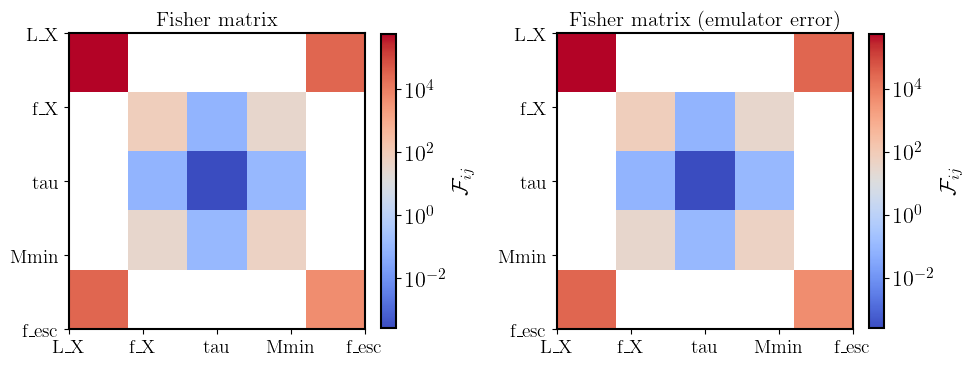

In [319]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))

im = ax[0].imshow(fish_ksz, cmap='coolwarm', norm=matplotlib.colors.LogNorm(),
               extent=(0, 2, 2, 0))
ax[0].set_xticks(ticks=np.arange(len(astro_pnames)) / 2, labels=astro_pnames, fontsize=14)
ax[0].set_yticks(ticks=np.arange(len(astro_pnames)) / 2,
              labels=astro_pnames, fontsize=14)
ax[0].set_title('Fisher matrix', fontsize=15)
cbar = plt.colorbar(im, ax=ax[0], fraction=0.045, label=r'$\mathcal{F}_{ij}$')


im = ax[1].imshow(fish_ksz_emu, cmap='coolwarm', norm=matplotlib.colors.LogNorm(),
               extent=(0, 2, 2, 0))
ax[1].set_xticks(ticks=np.arange(len(astro_pnames)) / 2, labels=astro_pnames, fontsize=14)
ax[1].set_yticks(ticks=np.arange(len(astro_pnames)) / 2,
              labels=astro_pnames, fontsize=14)
ax[1].set_title('Fisher matrix (emulator error)', fontsize=15)
cbar = plt.colorbar(im, ax=ax[1], fraction=0.045, label=r'$\mathcal{F}_{ij}$')
fig.tight_layout()

The covariance matrix is the inverse of the Fisher matrix:

In [320]:
fishcov_ksz = np.linalg.inv(fish_ksz)
fishcov_ksz_emu = np.linalg.inv(fish_ksz_emu)

In [321]:
fishcorr_ksz = np.zeros((4, 4))
fishcorr_ksz_emu = np.zeros((4, 4))

for i in range(4):
    for j in range(4):
        fishcorr_ksz[i, j] =fishcov_ksz[i, j]/np.sqrt(fishcov_ksz[i, i]*fishcov_ksz[j, j])

for i in range(4):
    for j in range(4):
        fishcorr_ksz_emu[i, j] =fishcov_ksz_emu[i, j]/np.sqrt(fishcov_ksz_emu[i, i]*fishcov_ksz_emu[j, j])

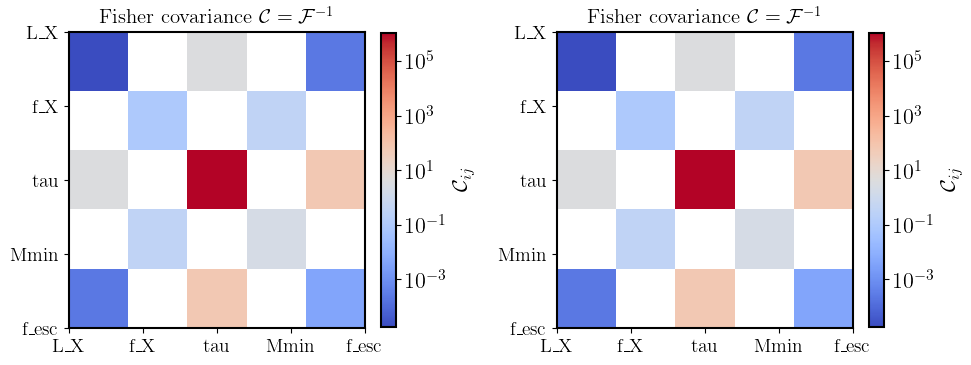

In [323]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))

im = ax[0].imshow(fishcov_ksz, cmap='coolwarm', norm=matplotlib.colors.LogNorm(),
               extent=(0, 2, 2, 0))
ax[0].set_xticks(ticks=np.arange(len(theta_labels)) / 2,
              labels=astro_pnames, fontsize=14)
ax[0].set_yticks(ticks=np.arange(len(theta_labels)) / 2,
              labels=astro_pnames, fontsize=14)
ax[0].set_title(r'Fisher covariance $\mathcal{C}=\mathcal{F}^{-1}$', fontsize=15)
cbar = plt.colorbar(im, ax=ax[0], fraction=0.045, label=r'$\mathcal{C}_{ij}$')

im = ax[1].imshow(fishcov_ksz, cmap='coolwarm', norm=matplotlib.colors.LogNorm(),
               extent=(0, 2, 2, 0))
ax[1].set_xticks(ticks=np.arange(len(theta_labels)) / 2,
              labels=astro_pnames, fontsize=14)
ax[1].set_yticks(ticks=np.arange(len(theta_labels)) / 2,
              labels=astro_pnames, fontsize=14)
ax[1].set_title(r'Fisher covariance $\mathcal{C}=\mathcal{F}^{-1}$', fontsize=15)
cbar = plt.colorbar(im, ax=ax[1], fraction=0.045, label=r'$\mathcal{C}_{ij}$')

fig.tight_layout()

Now we can define a distribution, given the "true" values of each model parameters and the above covariance matrix.

In [325]:
data_ksz = np.random.multivariate_normal(theta_true, fishcov_ksz, size=100000)
data_ksz_emu = np.random.multivariate_normal(theta_true, fishcov_ksz_emu, size=100000)

The forecast posterior distributions are plotted in a triangle plot:

In [324]:
fishcov_ksz /fishcov_ksz_emu

array([[0.99092962, 0.99308938, 0.99078233, 0.99082441, 0.98977304],
       [0.99308938, 0.99272714, 0.99262406, 0.99287276, 0.99200328],
       [0.99078233, 0.99262406, 0.99007923, 0.98991265, 0.98923918],
       [0.99082441, 0.99287276, 0.98991265, 0.9897651 , 0.98889242],
       [0.98977304, 0.99200328, 0.98923918, 0.98889242, 0.98865858]])

 Xray_Lfunc min=0.000192, max=0.0192
 Xray_Lfunc min=0.000192, max=0.0192
 Xray_Lfunc min=0.000192, max=0.0192
 Xray_Lfunc min=0.000192, max=0.0192
 Xray_Lfunc min=0.000192, max=0.0192
 hard_Xray_fraction min=0.0, max=1.0
 hard_Xray_fraction min=0.0, max=1.0
 hard_Xray_fraction min=0.0, max=1.0
 hard_Xray_fraction min=0.0, max=1.0
 gasconversion_timescale min=738.9, max=10504.7
 gasconversion_timescale min=738.9, max=10504.7
 gasconversion_timescale min=738.9, max=10504.7
 log10_Mmin min=8.0, max=9.6
 log10_Mmin min=8.0, max=9.6
 ion_escapefrac_post min=0.05, max=0.5


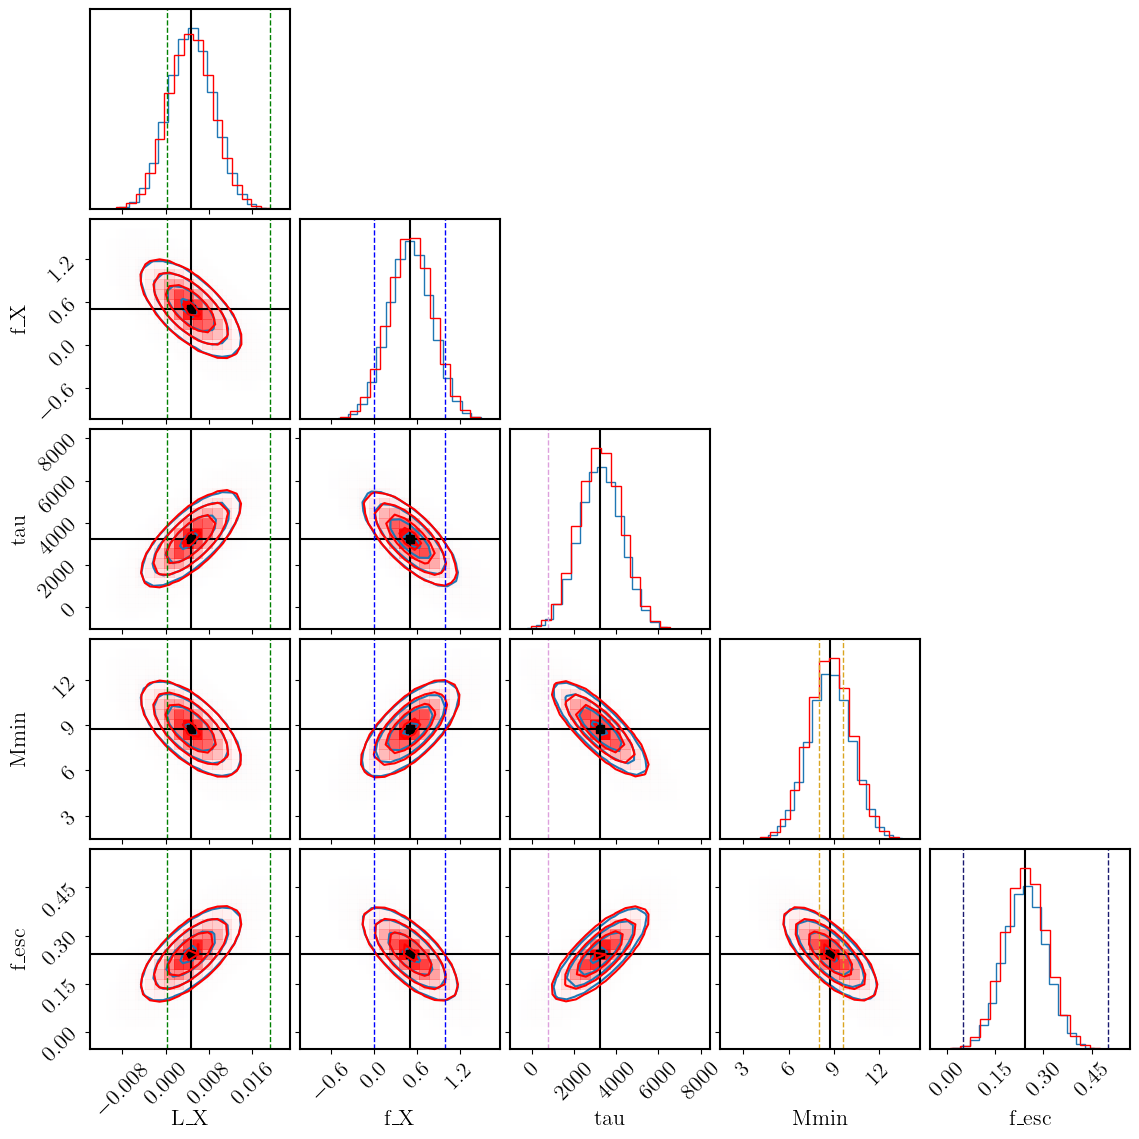

In [332]:
fig = corner.corner(data_ksz,
                  labels=astro_pnames,
                  sigmas=[1, 2], plot_datapoints=False, 
                  cmap='Blues', color='C0', lw=2., smooth=1.,
                #   extents=prio|r_bounds, 
                  truths=theta_true, truth_color='k')

fig = corner.corner(data_ksz_emu,
                  labels=astro_pnames,
                  sigmas=[1, 2], plot_datapoints=False, 
                  cmap='Reds', color='red', lw=2., smooth=1.,
                  fig=fig)
                #   extents=prio|r_bounds)

axes = np.asarray(fig.axes)  # Access all the axes in the corner plot
axes = axes.reshape(theta_true.size,theta_true.size)

# Loop through all axes and add vertical lines
for i in range(theta_true.size):
  for j in range(theta_true.size):
    if j >= i:
      print(f' {astro_labels[i]} min={df[astro_labels[i]].min()}, max={df[astro_labels[i]].max()}')
      axes[j,i].axvline(df[astro_labels[i]].min(), color=colors[i], linestyle="--", linewidth=1)
      axes[j,i].axvline(df[astro_labels[i]].max(), color=colors[i], linestyle="--", linewidth=1)


In [197]:
theta_true

array([4.62424270e-03, 4.99901226e-01, 3.38751792e+03, 8.80517961e+00,
       2.74457505e-01])

In [198]:
astro_labels

['Xray_Lfunc',
 'hard_Xray_fraction',
 'gasconversion_timescale',
 'log10_Mmin',
 'ion_escapefrac_post']

### MCMC fitting

In [488]:
def lnprob(theta, model, data, vars):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, model, data, vars)

def lnlike(theta, model, data, vars):
    test = model(theta) 
    return -0.5 * np.sum((data - test) ** 2 / np.diag(vars))

def lnprior(theta, priors=priors):
    for i, p in enumerate(priors):
        low, high = p
        if not (low <= check[i] <= high):
            return -np.inf
        
    # if np.all(low <= theta <= high for low, high in priors):
    #     return 0.0
    return -np.inf

In [485]:
for i, p in enumerate(priors):
    low, high = p
    print(low <= check[i] <= high)
    print(f'{low} <= {check[i]} <= {high}')

np.all((low <= check) & (check <= high) for low, high in priors)

False
0.000192 <= 1.91846485e+32 <= 0.0192
False
0.0 <= -1.72578726e+34 <= 1.0
False
738.9 <= 3.66762916e+38 <= 10504.7
False
8.0 <= 3.57464518e+34 <= 9.6
False
0.05 <= 2.95485409e+34 <= 0.5


np.True_

In [489]:
lnprior(check)

-inf

In [490]:
for i in samples:
    print(lnprob(i, model, data, vars))

-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf


In [462]:
check = [1.91846485e+32, -1.72578726e+34,  3.66762916e+38,  3.57464518e+34,
  2.95485409e+34]

In [471]:
lnprior(check)

0.0

In [491]:
lnprob(np.asarray(check), model, data, vars)

-inf

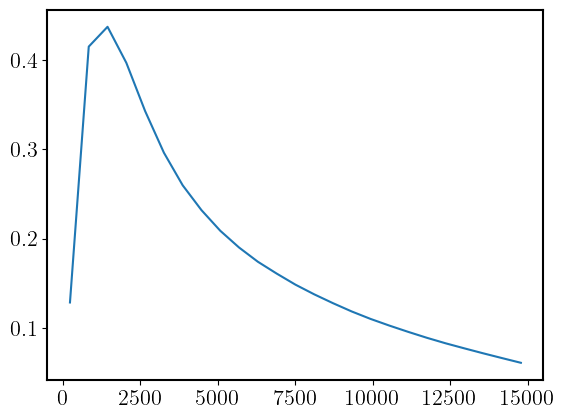

In [362]:
def model(theta):
    return regressor.predict(theta[None,:]).flatten()

vars = err_cov_emu
data = model(theta_true)

plt.plot(ells, data)

In [393]:
priors = [(df[p].min(), df[p].max()) for p in astro_labels]
priors

[(0.000192, 0.0192), (0.0, 1.0), (738.9, 10504.7), (8.0, 9.6), (0.05, 0.5)]

In [497]:
nwalkers = 32
ndim = len(theta_true)
p0 = theta_true[None,:] + .001 * np.random.rand(nwalkers, ndim)

In [401]:
p0 = [np.random.uniform(low, high, size=nwalkers) for low, high in priors]
p0 = np.vstack(p0).T
p0.shape

(32, 5)

In [498]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[model, data, var])
state = sampler.run_mcmc(p0, 100, progress=True)


  0%|          | 0/100 [00:00<?, ?it/s]/Users/emcbride/miniforge3/envs/kSZ/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [00:00<00:00, 4422.41it/s]


In [499]:
sampler.reset()
sampler.run_mcmc(state, 10000, progress=True)

100%|██████████| 10000/10000 [00:01<00:00, 5307.99it/s]


State([[5.09372293e-03 5.06933086e-01 3.23521001e+03 8.77123342e+00
  2.43737845e-01]
 [5.02201212e-03 5.06761625e-01 3.23521046e+03 8.77139340e+00
  2.43981123e-01]
 [5.17176726e-03 5.07083951e-01 3.23521024e+03 8.77138129e+00
  2.43678519e-01]
 [4.65754084e-03 5.06768871e-01 3.23521035e+03 8.77060743e+00
  2.43645589e-01]
 [4.71539029e-03 5.07309687e-01 3.23521054e+03 8.77125116e+00
  2.43702985e-01]
 [5.51842557e-03 5.07195769e-01 3.23521093e+03 8.77052835e+00
  2.43655967e-01]
 [4.73250844e-03 5.06712967e-01 3.23521026e+03 8.77143622e+00
  2.43433992e-01]
 [5.41173743e-03 5.06949299e-01 3.23521060e+03 8.77049294e+00
  2.43938116e-01]
 [5.42867629e-03 5.07283190e-01 3.23521020e+03 8.77128621e+00
  2.43899129e-01]
 [4.69016820e-03 5.06927950e-01 3.23521011e+03 8.77099856e+00
  2.43191880e-01]
 [5.60914480e-03 5.07060738e-01 3.23521069e+03 8.77096358e+00
  2.43531764e-01]
 [5.01278632e-03 5.07479506e-01 3.23521039e+03 8.77119962e+00
  2.43677878e-01]
 [4.73448958e-03 5.07594982e-01 3.

In [501]:
logps.min()

np.float64(-inf)

(25,)
(25,)


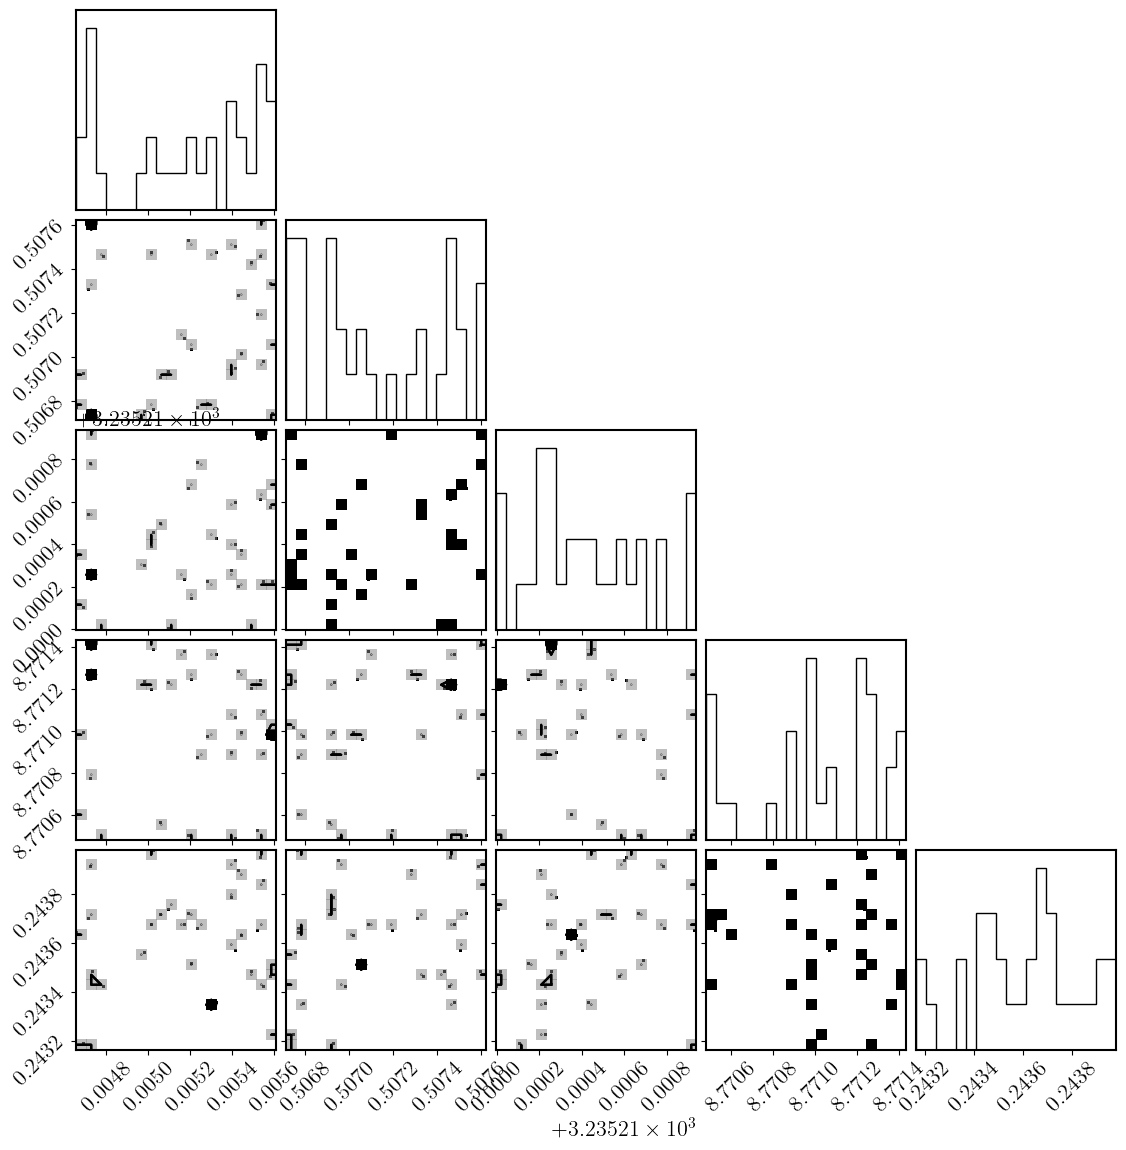

In [500]:
samples = sampler.get_chain(flat=True)
logps = sampler.get_log_prob(flat=True)

fig = corner.corner(samples, truths=theta_true)

axes = np.asarray(fig.get_axes())
print(axes.shape)
axes.reshape(5, 5) 
print(axes.shape)
# # axes.reshape(5, 5) 
# print(axes.shape) # Get the axes of the corner plot

# # Scatter the second dataset over the corner plot
# for i in range(ndim):         # Loop through dimensions
#     for j in range(i):
#         axes[i * (i - 1) // 2 + j].scatter(p0[:,i], p0[:,j], color='red')


# for i in range(1, ndim):       # Loop over rows (starting at 1 to skip diagonal)
#     for j in range(i):         # Loop over columns (lower triangle only)
#         index = i * (i - 1) // 2 + j  # Correct index in the flat axes list
#         ax = axes[index]
#         ax.scatter(p0[:, j], p0[:, i], color='red', s=10, alpha=0.5)
